Andrea Hanel 2024

# QC - part 2

Additional filtering - stricter MT %

>"Based on our analytical results, we suggest a standardized mtDNA% threshold of 10% for scRNA-seq QC of human samples." Osorio and Cai, Bioinformatics 2020 https://doi.org/10.1093/bioinformatics/btaa751

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

!echo "Conda Environment: $CONDA_DEFAULT_ENV"
from datetime import datetime
print(f"Date: {datetime.now():%Y-%m-%d}")

Conda Environment: tired_like_a_kitten
Date: 2024-11-24


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.3.0
anyio                       NA
argcomplete                 NA
arrow                       1.3.0
asttokens                   NA
attr                        24.2.0
attrs                       24.2.0
babel                       2.16.0
brotli                      1.1.0
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.5
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.2
executing                   2.1.0
fastjsonschema              NA
fqdn                        NA
gmpy2                       2.1.5
google                      NA
h5py                        3.11.0
idna                        3.7
igr

In [3]:
adata = sc.read_h5ad("../output/adata_julianfiltr.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 35046 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'gene_id', '2', 'n_cells'
    uns: 'sample_colors'

In [5]:
adata.obs.head(2)

,sample,etv6_runx1,barcode,n_counts,log_counts,n_genes,mt_frac
barcode,,,,,,,
AAACCCAAGCGAACTG-1,9_HW8_WT,WT,AAACCCAAGCGAACTG-1,29339.0,10.286673,5978,0.073997
AAACCCACAAGAGTTA-1,9_HW8_WT,WT,AAACCCACAAGAGTTA-1,37476.0,10.531456,7159,0.046803


In [6]:
# Remove prefix with numbers 
adata.obs['sample'] = adata.obs["sample"].str.replace(r'^\d+_', '', regex=True)
adata.obs['celline'] = adata.obs['sample'].str.split('_').str[0]

In [7]:
adata.obs.head(2)

,sample,etv6_runx1,barcode,n_counts,log_counts,n_genes,mt_frac,celline
barcode,,,,,,,,
AAACCCAAGCGAACTG-1,HW8_WT,WT,AAACCCAAGCGAACTG-1,29339.0,10.286673,5978,0.073997,HW8
AAACCCACAAGAGTTA-1,HW8_WT,WT,AAACCCACAAGAGTTA-1,37476.0,10.531456,7159,0.046803,HW8


In [8]:
MAX_MITO = 0.1

In [9]:
n_high_mt_fraction_cells = adata[adata.obs['mt_frac'] > MAX_MITO].shape[0]
print("High mitochondrial fraction cells:  {:d}".format(n_high_mt_fraction_cells))


High mitochondrial fraction cells:  2687


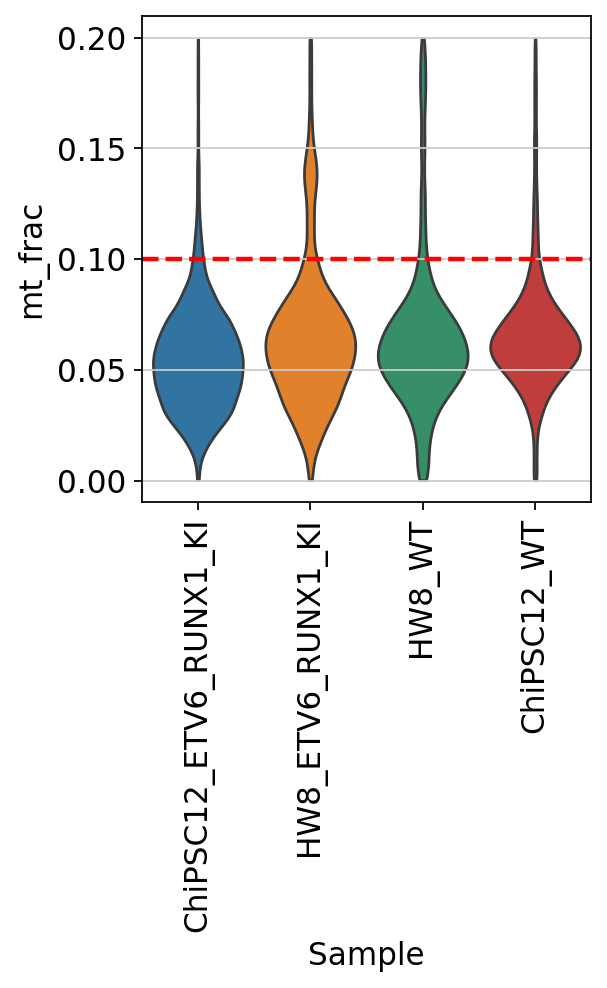

In [10]:
sc.set_figure_params(figsize=(4, 4))

sample_counts = adata.obs['sample'].value_counts().sort_values(ascending=False)
sorted_samples = sample_counts.index.tolist()
adata.obs['sample'] = pd.Categorical(adata.obs['sample'], categories=sorted_samples, ordered=True)

sc.pl.violin(adata, keys="mt_frac", groupby="sample", stripplot=False, rotation=90, 
             xlabel='Sample', ylabel='mt_frac', show=False)

plt.axhline(y=MAX_MITO, color='red', linestyle='--', linewidth=2)
plt.show()


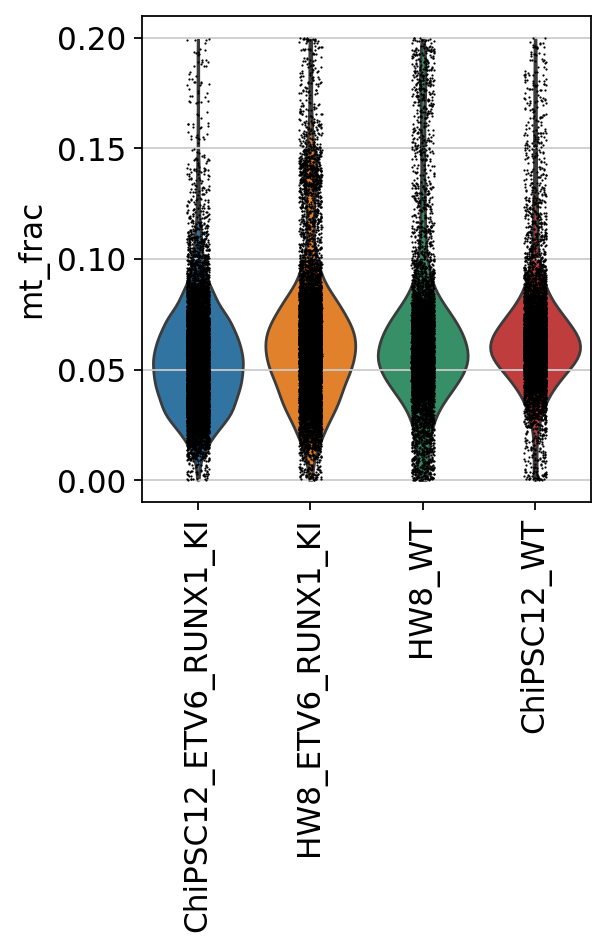

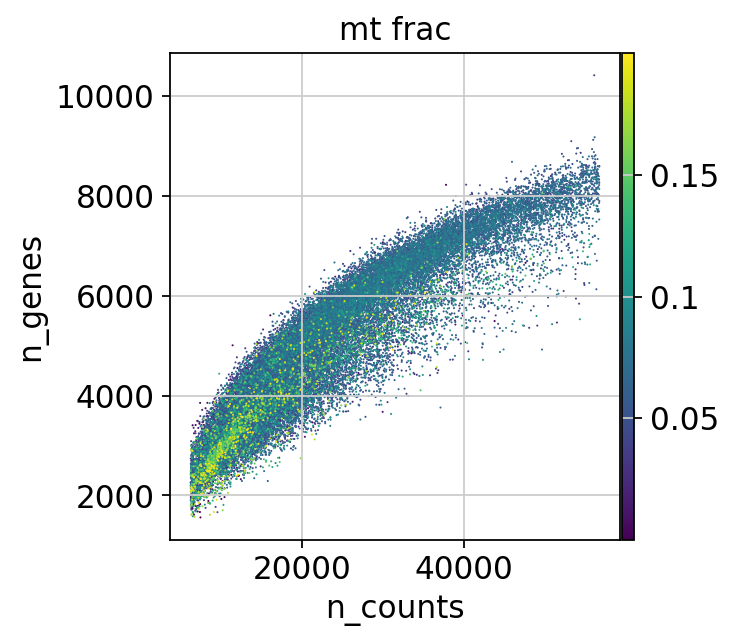

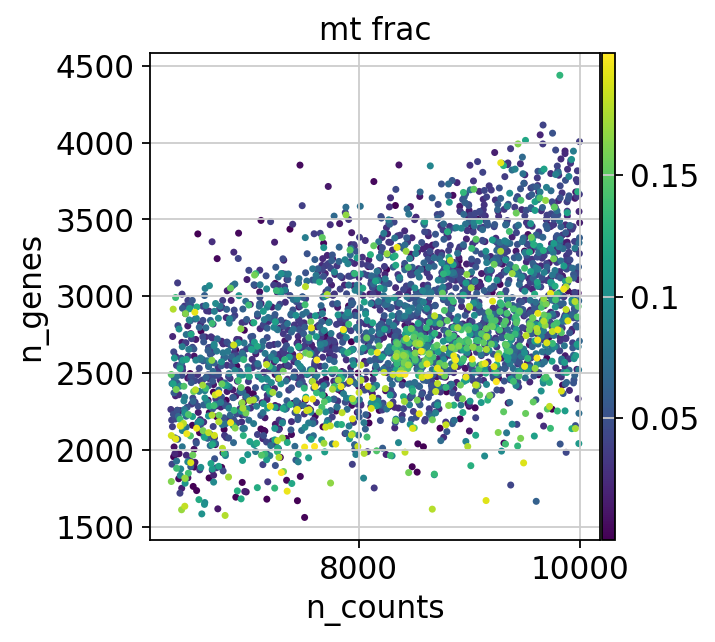

In [11]:
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample', rotation=90)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

In [12]:
adata = adata[adata.obs['mt_frac'] < MAX_MITO].copy()
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Number of cells after MT filter: 32358


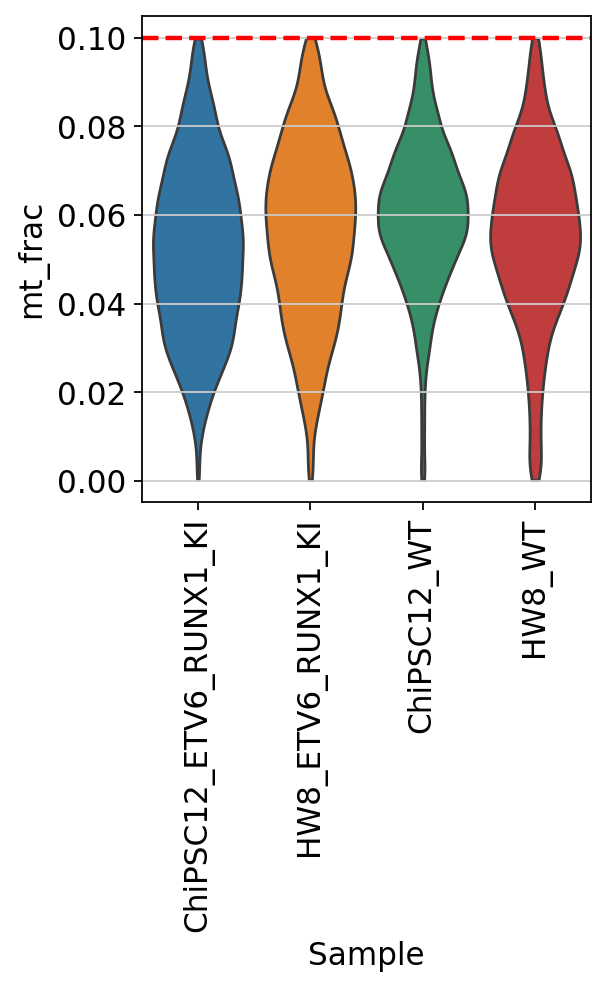

In [13]:
sc.set_figure_params(figsize=(4, 4))

sample_counts = adata.obs['sample'].value_counts().sort_values(ascending=False)
sorted_samples = sample_counts.index.tolist()
adata.obs['sample'] = pd.Categorical(adata.obs['sample'], categories=sorted_samples, ordered=True)

sc.pl.violin(adata, keys="mt_frac", groupby="sample", stripplot=False, rotation=90, 
             xlabel='Sample', ylabel='mt_frac', show=False)

plt.axhline(y=MAX_MITO, color='red', linestyle='--', linewidth=2)
plt.show()


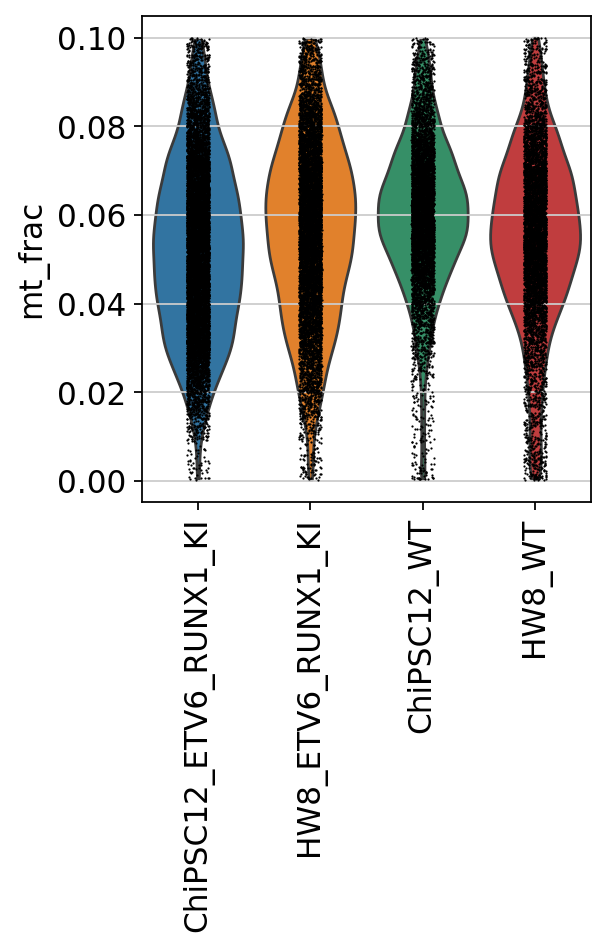

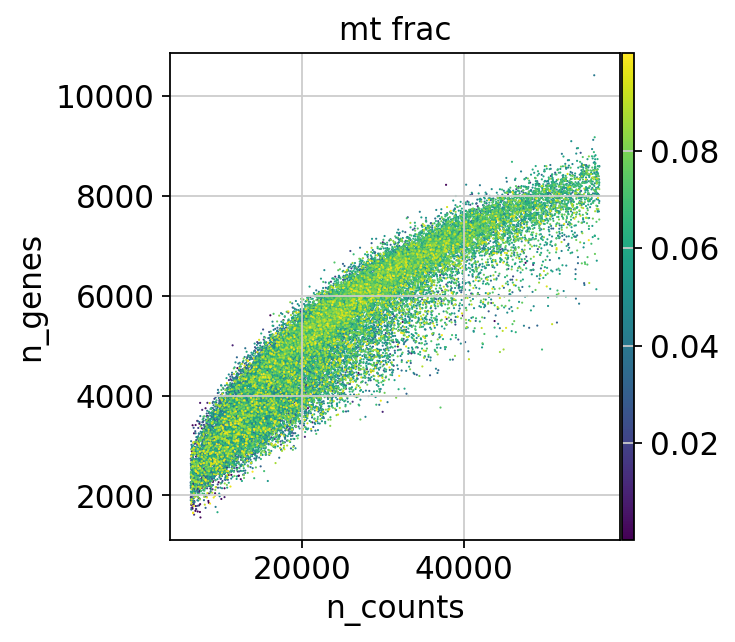

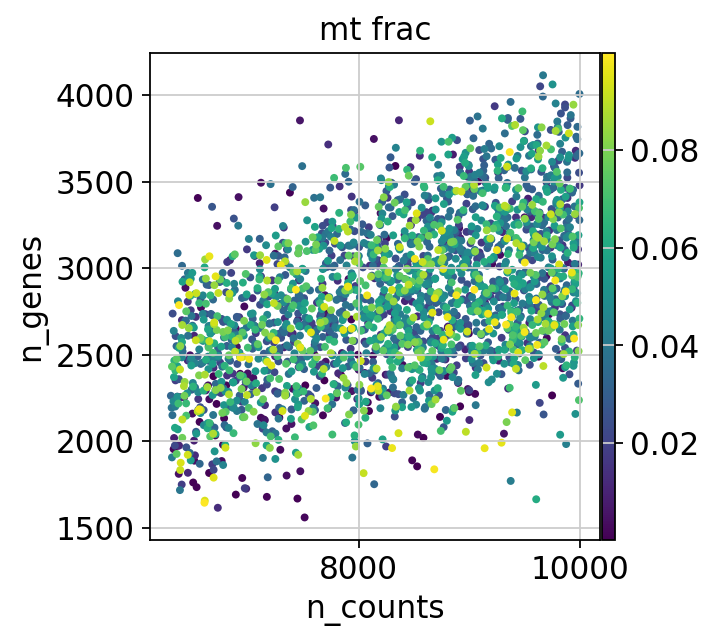

In [14]:
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample', rotation=90)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

## Normalize

In [15]:
adata.layers["raw_counts"] = adata.X
scales_counts = sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adata

AnnData object with n_obs × n_vars = 32358 × 33233
    obs: 'sample', 'etv6_runx1', 'barcode', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'celline'
    var: 'gene_id', '2', 'n_cells'
    uns: 'sample_colors'
    layers: 'raw_counts', 'log1p_norm'

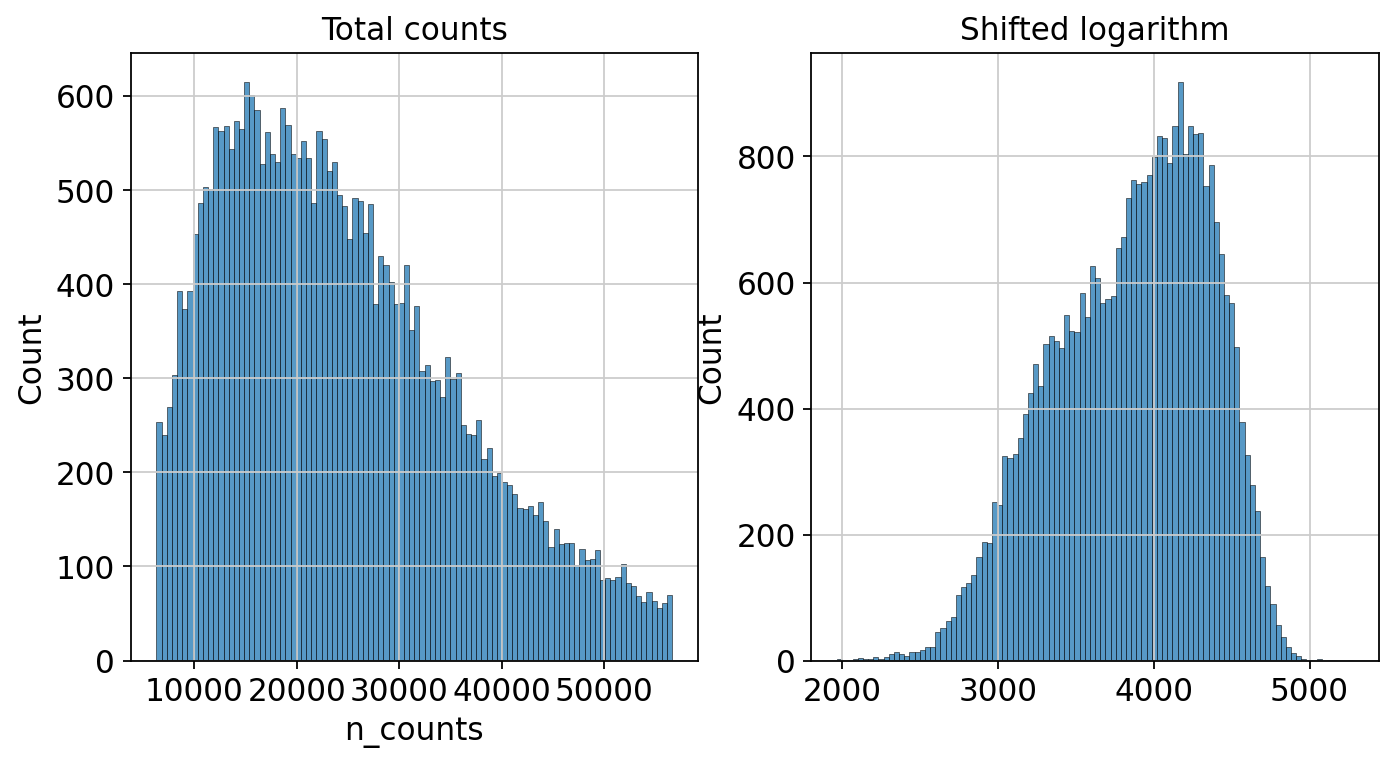

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["n_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [17]:
adata.write ("/research/groups/sysgen/PROJECTS/sysgen_team/andrea_work/2023_Fischer_iPSC/revision_final/data/adata2_norm.h5ad")
